# Defining a value object

Since we want to compute the derivatives of values, which can also be computed by using various expressions, we need an efficient way of storing the value and it's derivatives for later processing.

Since we're wrapping the values in an object we need a way to perform operations on it. We do this by overriding specific dunder/magic methods.

- `*`: `__mul__(self, other)`
- `+`: `__add__(self, other)`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [29]:
class Value:
    def __init__(self, data, _children=(), _op: str = None, label: str = ""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __mul__(self, other):
        return Value(self.data * other.data, _children=(self, other), _op="*")

    def __add__(self, other):
        return Value(self.data + other.data, _children=(self, other), _op="+")

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, _children=(self,), _op="tanh")
        return out

In [3]:
v = Value(2.0)
v

Value(data=2.0)

# Creating a simple example

We're going to use the following as an example for backpropagation

Given:
$$
\begin{split}
a = -3 \\
b = 2 \\
c = 10 \\
f = -2 \\
\end{split}
$$

and:

$$
\begin{split}
e = a \cdot b\\
d = e + c
\\
L = d \cdot f
\end{split}
$$

In [4]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")

print(a * b)

c = Value(10.0, label="c")
e = b * a
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"
L1 = L.data
print(d)
print(d._prev)
print(f)

Value(data=-6.0)
Value(data=4.0)
{Value(data=10.0), Value(data=-6.0)}
Value(data=-2.0)


# Drawing the computational graph

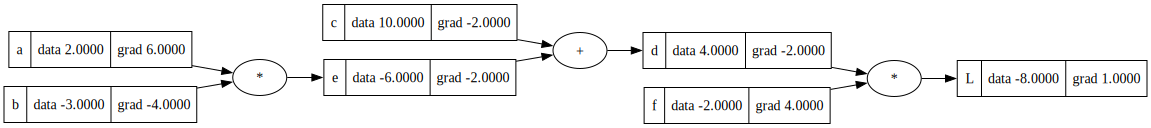

In [7]:
# Visualizing the computation graph
from graphviz import Digraph
from networkx import nodes


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


# for any value use a rectangle, for any operation use a circle
def draw_graph(value: Value):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # Left to right
    nodes, edges = trace(value)
    # For each node, add a rectangle with the value
    for n in nodes:
        uid = str(id(n))
        dot.node(
            name=uid,
            label="{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        # For any operation, use a circle
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            # Add edges to the graph
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


draw_graph(L)

# Manual backpropagation on the example

We have:

$$
L = d * f
$$

, and we would like to know:

$$
\frac{d_L}{d_d} = ?
$$


Definition of derivative is:

$$
\frac{f(x+h) - f(x)}{h}
$$

If L = d * f, increasing the value of d, and f, in this case is a constant, we get:

$$
\frac{(d+h)*f - d*f}{h}
$$
which reduces down to:

$$
\frac{d*f + h*f -d*f}{h} = \frac{h*f}{h} = f
$$

In [6]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data

c.grad = d.grad
e.grad = d.grad

a.grad = e.grad * b.data
b.grad = e.grad * a.data

## Staging Area
This is to test things out and to not mess up the global variable scope

In [25]:
def lol():

    h = 0.001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f
    L.label = "L"
    L1 = L.data

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f
    L.label = "L"
    L2 = L.data + h

    print((L2 - L1) / h)


lol()

1.000000000000334


# Neural Network example

We're now going to consider a more concrete example on how to compute gradients in a neural network by considering a neuron with multiple weights and inputs, as well as an activation function

<!-- Embed the image -->
<img src="../img/neuron_model-cs231n.jpeg" alt="Definition of a neuron taken from CS231n">

We're going to use $\tanh$ as an activation function for the neuron.

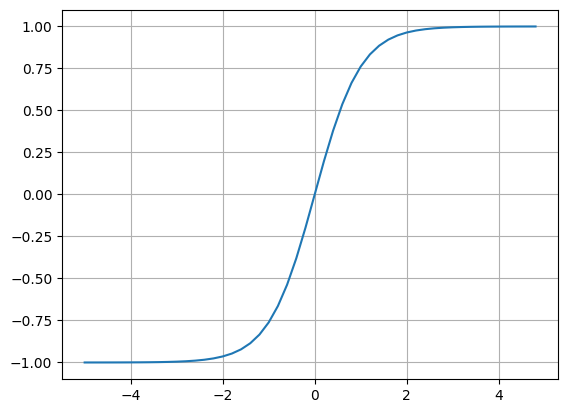

In [26]:
x = np.arange(-5, 5, 0.2)
y = np.tanh(np.arange(-5, 5, 0.2))

plt.grid()
plt.plot(x, y)

In [31]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights wl,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")  # Value set so the numbers come out "nice"
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

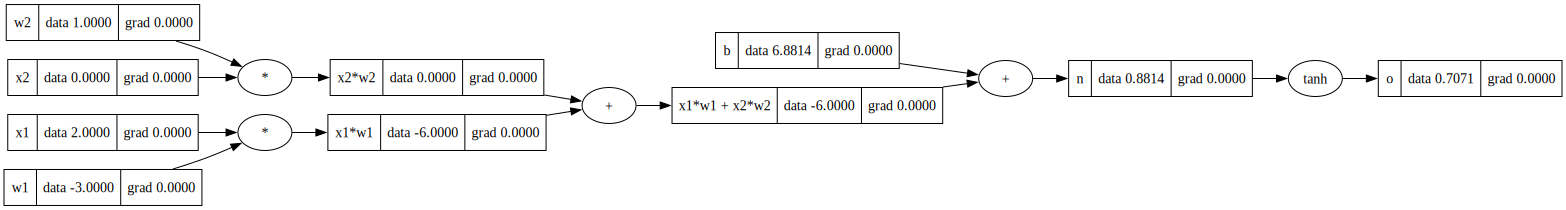

In [32]:
draw_graph(o)

## Manual Backprob
We're now going to determine the gradients of the variables with respect to the output

1. We start with the base case. $o$:
    
    $\frac{d_o}{d_o} = 1$.

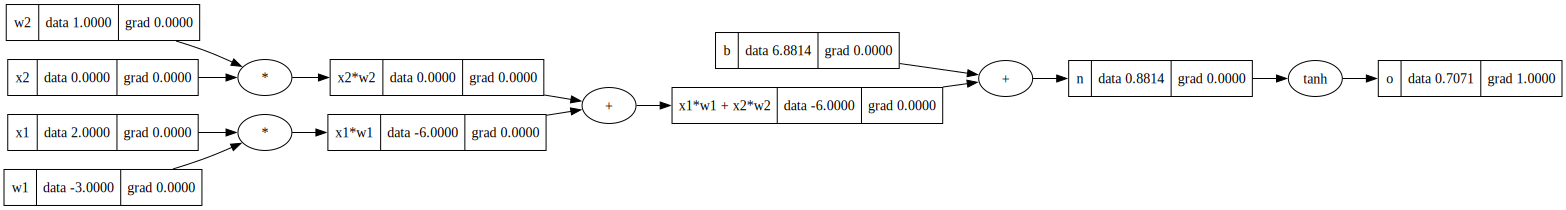

In [33]:
o.grad = 1.0

draw_graph(o)

2. We then continue with $\frac{d_o}{d_n}$:
    
    $$
    \frac{d_o}{d_n} = 1-\tanh^2(x)
    $$

   Since we already compute $\tanh(x)$ we can use the value by extracting it from ``o.data`` so that we get:


In [37]:
# do/dn = 1 - tanh(n) ** 2
# We've already put n through tanh therfore we're left with:
1 - o.data**2

0.4999999999999999

which is roughly $0.5$

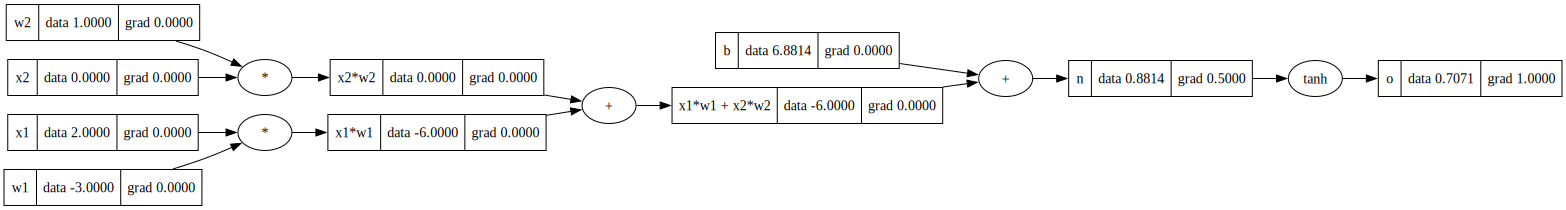

In [35]:
n.grad = 0.5
draw_graph(o)

$+$ Nodes then distribute the gradients backward through the graph:

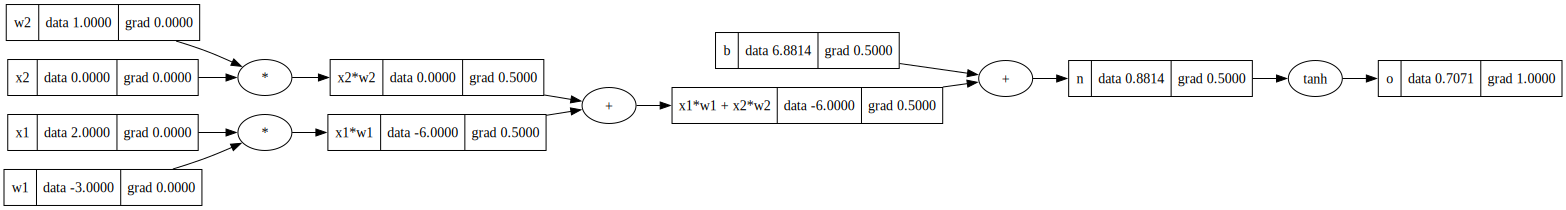

In [38]:
# + Nodes distribute the gradients so
b.grad = 0.5
x1w1x2w2.grad = 0.5

x2w2.grad = 0.5
x1w1.grad = 0.5

draw_graph(o)

$*$ Nodes multiply the result of the previous node with the local derivative, which the value of the other node:

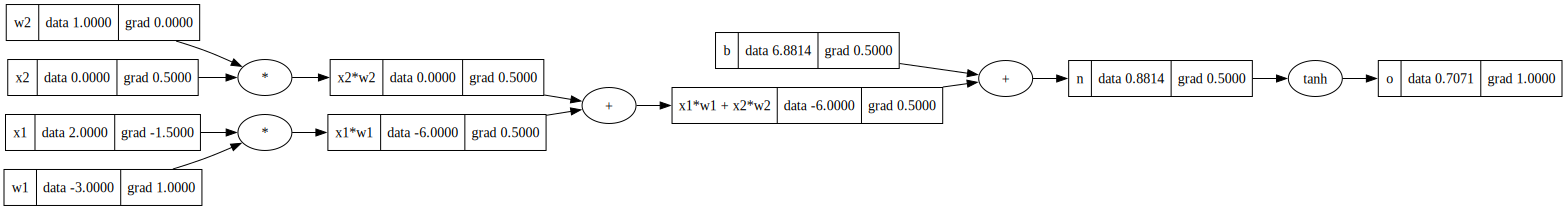

In [39]:
# Multiplication is always tha value of the counterpart times the previous gradient (chain rule)
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

draw_graph(o)

## Observation
We see that the gradient of $w_2$ is $0$, this means that now matter how much we change $w_2$ it's not going to change the output, because the gradient is $0$.

This means: **$w_2$ is not affecting the outcome!**

Since the only thing in a neuron we can change to influence the outcome are the weights and the outcome does not respond to changes in $w_2$, the only thing we can change to affect the outcome is $w_1$!

# Interpretation

The gradients of the individual variables tell us how the output is going to respond to changes of that variable:

- If the gradient is negative $< 0$: The output is going down
- If the gradient is positive $> 0$: The output us going up
- If the gradient is $0$: Changing this variable will have no effect on the output

# Changing the parameters based on the gradients
``h = 0.001``

``w2_h = 1000``

``w1_h = h``


We normally canot cange inputs but to demonstrate the effect of a variable with a negative gradient, we're going to bump $x1$

``x1h = h``
    

In [28]:
def lol2():
    # Change rate
    h = 0.001
    
    # inputs x1,x2
    x1 = Value(2.0, label="x1")
    x2 = Value(0.0, label="x2")
    # weights wl,w2
    w1 = Value(-3.0, label="w1")
    w2 = Value(1.0, label="w2")
    # bias of the neuron
    b = Value(6.8813735870195432, label="b")  # Value set so the numbers come out "nice"
    # x1*w1 + x2*w2 + b
    x1w1 = x1 * w1
    x1w1.label = "x1*w1"
    x2w2 = x2 * w2
    x2w2.label = "x2*w2"
    x1w1x2w2 = x1w1 + x2w2
    x1w1x2w2.label = "x1*w1 + x2*w2"
    n = x1w1x2w2 + b
    n.label = "n"
    o = n.tanh()
    o.label = "o"
    print(o.data)

lol2()

0.7071067811865476
